# Hamiltonian Monte Carlo
### (Or: watch your "p's"s and "q's")

Hamiltonian physics is a re-imagining (of sorts) of the fundamental idea of the conservation of energy. 

The classical formulation goes something like the following. Assume we have a particle, whose position is denoted by the variable $\bf{q}$. The momentum of such a particle is defined by the fomula $\bf{p=mv}$, where $\bf{v}$ is the first derivative of the position variable, $\bf{\dot{q}}$.

The kinetic and potential energy of this particle may be represented as:

$$\bf{K(p,q) = \frac{1}{2}m\dot{q}^2 \hspace{1in} U(q)} $$

With the $Hamiltonian$ written as the sum of the kinetic and potential energies (scalable to many particles, if needed):

$$\bf{H = K(p,q) + U(q) = \frac{1}{2}m\dot{q}^2 + U(q) }$$

or

$$\bf{H = \frac{p}{2m} + U(q)}$$

The equation of motion for the particle (or system, for many particles) are given by $Hamilton's~ Equations$:

$$\boxed{\bf{q=\frac{\partial H}{\partial p}}} \hspace{1in} \boxed{\bf{p=-\frac{\partial H}{\partial q}}}$$

This is all fine and dandy, but really? $Why~do~we~care$?

Keep this in mind as we move forward: the solution of Hamilton's equations yields a trajectory $-$ positions and momenta as functions of time.

### Some (re-)definitions

For purposes here, Markov chain Monte Carlo (MCMC) is a method to determine expectations (some value of interest) from the posterior distribution of our model. To avoid a [traxoline](https://people.physics.tamu.edu/krisciunas/Traxoline.pdf) moment, the best explanation for this that I've found is: the posterior distribution is a probability distribution that represents your updated beliefs about the parameter after having seen the data. From this probability distribution, we can estimate the value of interest, as well as uncertainties in said value. 

We need the MCMC to converge to the true expectation value (true estimate) quickly. Fast convergence requires strong conditions of $\bf{ergodicity}$ - that is, a parameter space may be sufficiently explored statistically by MCMC in a finite amount of time. Specifically, the condition of geometric ergodicity is desirable. In this condition, MCMC estimators follow the central limit theorum, and the properly normalized sum of the probability distribution or posterior, tends towards a normal, or Gaussian distribution. $\bf{Geometric~ergodicity}$ applies to manifolds (high-dimentional surfaces) and has been historically important in the development of differential geometric analyses, such as General Relativity. 

$Hamiltonian~Monte~Carlo~(\bf{HMC})$ is unique in that when it fails to converge, it is recognisable. For example, with the split $\hat{\bf{R}}$ statistic, which for well-behaved parameter spaces, should be very near 1.0, and values above 1.1 indicate problems with the fit.

### Hamiltonian Monte Carlo application

Using Hamiltonian dynamics to sample from a distribution requires translating the density function for this distribution to a potential energy function and introducing "momentum" variables to go with the original variables of interest (now seen as "position" variables). We can then simulate a Markov chain in which each iteration resamples the momentum and then does a Metropolis update with a proposal found using Hamiltonian dynamics.

The first step of the HMC process changes only the momentum, with new values randomly extracted from a Gaussian distribution. In the second step, a Metropolis update is performed, using Hamiltonian dynamics to propose a new state. Care must be taken in choosing the number of steps and step size to avoid problems, such as periodicity in parameter space exploration.

### Why HMC?

Let's explore an example, at least graphically, why one might wish to use HMC over other types of MCMC estimation. This example will contrast HMC and random-walk Metropolis MCMC via a 100-dimensional multivariate Gaussian distribution in which the varialbes are independant, with means of zero, and standard deviations of 0.01, 0.02, ..., 0.99, 1.00. The results of the simulations are best seen in a series of plots.

<img src="Location_plot.jpg">
<img src="Accuracy.jpg">

### References:

1. http://www.mcmchandbook.net/HandbookChapter5.pdf
2. http://stats.stackexchange.com/questions/58564/help-me-understand-bayesian-prior-and-posterior-distributions
3. http://www.nyu.edu/classes/tuckerman/stat.mech/lectures/lecture_1/node4.html
4. http://mc-stan.org/users/documentation/case-studies/pystan_workflow.html


## Example: The stellar IMF with Metropolis-Hastings and with HMC

Salpeter (1955) found that the stellar initial mass function (IMF) for stars above 1$M_\odot$ has a power law form:

$\frac{dN}{dM} \propto \frac{M}{M_\odot}^{-\alpha} ~~ or ~~ \frac{dN}{dlogM} \propto \frac{M}{M_\odot}^{1-\alpha}$

and he estimated $\alpha=2.35$.

Here we will create a set of test stellar mass data, distributed according to the Salpeter mass function, and then we will perform a Markov Chain to guess this (known) slope.  
We will give an example using the Metropolis MCMC, and then perform the same procedure with Hamiltonian dynamics.

We are given then a set of N stellar masses, with negligible errors in the measurements.
Assuming that the minimum and maximum masses are known, the likelihood of the problem is: 

$\mathcal L(\{M_1,M_2,\ldots,M_N\};\alpha) = \prod_{n=1}^N p(M_n|\alpha) = \prod_{n=1}^N c\left(\frac{M_n}{M_\odot}\right)^{-\alpha}$

where the normalization constant c can be found by:

$\int_{M_{min}}^{M_{max}}c M^{-\alpha} dM = 1 \Rightarrow c\frac{M_{max}^{1-\alpha}-M_{min}^{1-\alpha}}{1-\alpha}=1$

First, let's create a function that will construct a Salpeter IMF:

In [42]:
import math
import random

def sampleFromSalpeter(N, alpha, M_min, M_max):
    # Draw random samples from a Salpeter IMF.
    # N     ... number of samples.
    # alpha ... power-law index.
    # M_min ... lower bound of mass interval.
    # M_max ... upper bound of mass interval.
    # Convert limits from M to logM.
    log_M_Min = math.log(M_min)
    log_M_Max = math.log(M_max)
    # Since the Salpeter SMF has a negative slope, maximum likelihood occurs at M_min
    maxlik = math.pow(M_min, 1.0 - alpha)
    
    # Prepare array for output masses.
    Masses = []
    # Fill in array.
    while (len(Masses) < N):
        # Draw a candidate from logM interval.
        logM = random.uniform(log_M_Min,log_M_Max)
        M    = math.exp(logM)
        # Compute likelihood of candidate from Salpeter SMF.
        likelihood = math.pow(M, 1.0 - alpha)
        # Accept randomly.
        u = random.uniform(0.0,maxlik)
        if (u < likelihood):
            Masses.append(M)
    return Masses

We need to define the logarithmic likelihood function:

In [43]:
def evaluateLogLikelihood(params, D, N, M_min, M_max):
    # Define logarithmic likelihood function.
    # params ... array of fit params, here just alpha
    # D      ... sum over log(M_n)
    # N      ... number of data points.
    # M_min  ... lower limit of mass interval
    # M_max  ... upper limit of mass interval
    alpha = params[0]  # extract alpha
    # Compute normalisation constant.
    c = (1.0 - alpha)/(math.pow(M_max, 1.0-alpha)
                        - math.pow(M_min, 1.0-alpha))
    # return log likelihood.
    return N*math.log(c) - alpha*D

Now we can generate our toy data:

In [44]:
import numpy as np

N      = 1000000  # Draw 1 Million stellar masses.
alpha  = 2.35
M_min  = 1.0
M_max  = 100.0
log_M_min  = np.log10(M_min)
log_M_max  = np.log10(M_max)
Masses = sampleFromSalpeter(N, alpha, M_min, M_max)
LogM   = np.log(np.array(Masses))
D      = np.mean(LogM)*N

And we are ready to initialize our MCMC as we saw the previous time:

In [94]:
# initial guess for alpha as a list.
guess = [3.0]
# Prepare storing MCMC chain as list of lists.
A = [guess]
# define stepsize of MCMC.
stepsizes = [0.0005]  # list of stepsizes
accepted  = 0.0

In [95]:
# Metropolis-Hastings with 10,000 iterations.
for n in range(10000):
    old_alpha  = A[len(A)-1]  # old parameter value as array
    old_loglik = evaluateLogLikelihood(old_alpha, D, N, M_min,
                    M_max)
    # Suggest new candidate from Gaussian proposal distribution.
    new_alpha = np.zeros([len(old_alpha)])
    for i in range(len(old_alpha)):
        # Use stepsize provided for every dimension.
        new_alpha[i] = random.gauss(old_alpha[i], stepsizes[i])
    new_loglik = evaluateLogLikelihood(new_alpha, D, N, M_min,
                    M_max)
    # Accept new candidate in Monte-Carlo fashing.
    if (new_loglik > old_loglik):
        A.append(new_alpha)
        accepted = accepted + 1.0  # monitor acceptance
    else:
        u = random.uniform(0.0,1.0)
        if (u < math.exp(new_loglik - old_loglik)):
            A.append(new_alpha)
            accepted = accepted + 1.0  # monitor acceptance
        else:
            A.append(old_alpha)

print("Acceptance rate = "+str(accepted/10000.0))

Acceptance rate = 0.7706


In [96]:
# Discard first half of MCMC chain and thin out the rest.
Clean = []
for n in range(5000,10000):
    if (n % 10 == 0):
        Clean.append(A[n][0])

In [97]:
# Print Monte-Carlo estimate of alpha.
print("Mean:  "+str(np.mean(Clean)))
print("Sigma: "+str(np.std(Clean)))

Mean:  2.35290377401
Sigma: 0.00124581193872


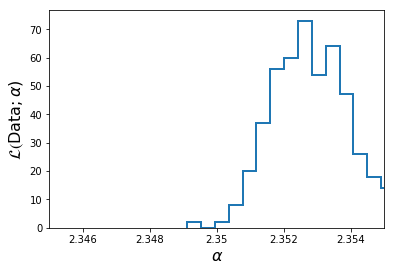

In [98]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.hist(Clean, 20, histtype='step', lw=2)
plt.xticks([2.346,2.348,2.35,2.352,2.354],
           [2.346,2.348,2.35,2.352,2.354])
plt.xlim(2.345,2.355)
plt.xlabel(r'$\alpha$', fontsize=16)
plt.ylabel(r'$\cal L($Data$;\alpha)$', fontsize=16)
plt.show()

Now we can run the same example using a Hamiltonian MC.  This means that, instead of our next guess being completely random, it will be instructed by the gradient of the log-likelihood:

$\frac{\partial log\cal{L}}{\partial\alpha} = -D - \frac{N}{1-\alpha}\left[1+\frac{1-\alpha}{M_{max}^{1-\alpha}-M_{min}^{1-\alpha}}\left(M_{max}^{1-\alpha}logM_{min}-M_{min}^{1-\alpha}logM_{max}\right)\right]$

First, we will need a function that evaluates this gradient.

In [27]:
def evaluateGradient(params, D, N, M_min, M_max, logMmin, logMmax):

    alpha = params[0]  # extract alpha
    grad = logMmin*math.pow(M_min, 1.0-alpha) - logMmax*math.pow(M_max, 1.0-alpha)
    grad = 1.0 + grad*(1.0 - alpha)/(math.pow(M_max, 1.0-alpha)
            - math.pow(M_min, 1.0-alpha))
    grad = -D - N*grad/(1.0 - alpha)
    return np.array(grad)

Then, like before, we need to initialize our chain and set a stepsize:

In [38]:
guess = [3.0]
A = [guess]
# define stepsize of HMC.
stepsize = 0.00004
accepted  = 0.0

The last thing we are going to need is an algorithm that evolves the dynamics of the system according to its "Hamiltonian", in this case the gradient of the log likelihood function.  Here we are going to use the Leapfrog algorithm, commonly used to integrate Hamiltonian systems since it exactly preserves energy at the end of each step.

Leapfrog integrates the equations of motion of a system by splitting the time step, dt, into two halves.  In short, the algorithm can be summarized as follows:

Starting from an initial condition (${\bf{x_0,p_0}}$),

1. Take half a step to update the momentum: 

$p_i(t+dt/2) = p_i(t) - dt/2\frac{\partial U}{\partial x_i(t)}$

2. Take an entire step to update the position:

$x_i(t+dt) = x_i(t) + dt\frac{\partial K}{\partial p_i(t+dt/2)}$

3. Take the other half step to update the momentum:

$p_i(t+dt) = p_i(t+dt/2) - dt/2\frac{\partial U}{\partial x_i(t+dt)}$



In [39]:
import copy

# Hamiltonian Monte-Carlo.
for n in range(50000):
    old_alpha  = A[len(A)-1]
    # Remember, energy = -loglik
    old_energy = -evaluateLogLikelihood(old_alpha, D, N, M_min, M_max)
    old_grad   = -evaluateGradient(old_alpha, D, N, M_min, M_max, log_M_min, log_M_max)

    new_alpha = copy.copy(old_alpha)  # deep copy of array
    new_grad  = copy.copy(old_grad)   # deep copy of array
    # Suggest new candidate using gradient + Hamiltonian dynamics.
    # draw random momentum vector from unit Gaussian.
    p = random.gauss(0.0, 1.0)
    H = np.dot(p,p)/2.0 + old_energy    # compute Hamiltonian

    # Do 5 Leapfrog steps.
    for tau in range(5):
        # make half step in p
        p         = p - stepsize*new_grad/2.0
        # make full step in alpha
        new_alpha = new_alpha + stepsize*p
        # compute new gradient
        new_grad  = -evaluateGradient(old_alpha, D, N, M_min,
                         M_max, log_M_min, log_M_max)
        # make half step in p
        p         = p - stepsize*new_grad/2.0

    # Compute new Hamiltonian. Remember, energy = -loglik.
    new_energy = -evaluateLogLikelihood(new_alpha, D, N, M_min,
                     M_max)
    new_grad  = -evaluateGradient(old_alpha,D, N, M_min,
                         M_max, log_M_min, log_M_max)
    newH       = np.dot(p,p)/2.0 + new_energy
    dH         = newH - H

    # Accept new candidate in Monte-Carlo fashion.
    if (dH < 0.0):
        A.append(new_alpha)
        accepted = accepted + 1.0
    else:
        u = random.uniform(0.0,1.0)
        if (u < math.exp(-dH)):
            A.append(new_alpha)
            accepted = accepted + 1.0
        else:
            A.append(old_alpha)

print("Acceptance rate = "+str(accepted/float(len(A))))

Acceptance rate = 0.6017679646407071


In [40]:
# Discard first half of MCMC chain and thin out the rest.
Clean = []
for n in range(len(A)//2,len(A)):
    if (n % 10 == 0):
        Clean.append(A[n][0])
        
# Print Monte-Carlo estimate of alpha.
print("Mean:  "+str(np.mean(Clean)))
print("Sigma: "+str(np.std(Clean)))

Mean:  2.35058263556
Sigma: 0.00143177309357


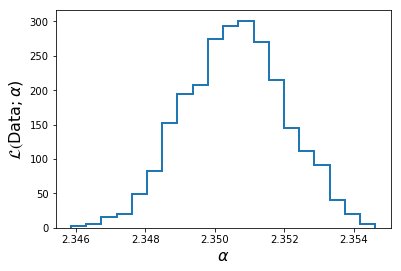

In [41]:
plt.figure(1)
plt.hist(Clean, 20, histtype='step', lw=2)
#plt.xlim(2.3,2.358)
plt.xlabel(r'$\alpha$', fontsize=16)
plt.ylabel(r'$\cal L($Data$;\alpha)$', fontsize=16)
plt.show()
